In [15]:
import io, json, os, math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms as transforms

from sklearn.metrics import f1_score
import ray
import pickle

import numpy as np
import gdown
from PIL import Image
import matplotlib.pyplot as plt

---

**Table of contents**<a id='toc0_'></a>    
- [1. 경로 설정](#toc1_)    
- [2. 주요 파라미터 설정](#toc2_)    
- [3. 데이터 개요](#toc3_)    
- [4. custom dataset](#toc4_)    
- [5. preprocessor](#toc5_)    
- [6. Hourglass 모델 만들기](#toc6_)    
  - [6-1. Hourglass 학습 엔진(dataloader 포함)](#toc6_1_)    
  - [6-2. Hourglass 예측 엔진](#toc6_2_)    
- [7. SimpleBaseline 모델 만들기](#toc7_)    
  - [7-1. SimpleBaseline 학습 엔진](#toc7_1_)    
  - [7-2. SimpleBaseline 예측엔진](#toc7_2_)    
- [8. 모델 비교 요약](#toc8_)
  - [8-1. loss 비교](#toc8_1_)
  - [8-2. f1-score 비교](#toc8_2_)
  - [8-3. test.jpg 비교](#toc8_3_)
- [9. 회고](#toc9_)

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=20
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

---

# <a id='toc1_'></a>[1. 경로 설정](#toc1_)

In [16]:
# 프로젝트 경로 설정
PROJECT_PATH = os.path.join(os.getenv("HOME"), 'wsl_workspace/aiffel_prac/cv_09')
print(PROJECT_PATH)

DATA_PATH = os.path.join(PROJECT_PATH, 'mpii')
IMAGE_PATH = os.path.join(DATA_PATH, 'images')
MODEL_PATH = os.path.join(DATA_PATH, 'models')
TRAIN_JSON = os.path.join(DATA_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(DATA_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

/home/suho/wsl_workspace/aiffel_prac/cv_09


---

# <a id='toc2_'></a>[2. 주요파라미터 설정](#toc2_)

In [17]:
NUM_TRAIN_SHARDS = 64
NUM_VAL_SHARDS = 8

IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

EPOCHS = 12
TRAIN_BATCH_SIZE = 16
NUM_HEATMAP = 16
LEARNING_RATE = 0.0007

---

# <a id='toc3_'></a>[3. 데이터 개요](#toc3_)

In [18]:
# json 파일이 어떻게 구성되었는지 확인해보자
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


**각 joint의 순서는 아래와 같음**
- 0 - 오른쪽 발목
- 1 - 오른쪽 무릎
- 2 - 오른쪽 엉덩이
- 3 - 왼쪽 엉덩이
- 4 - 왼쪽 무릎
- 5 - 왼쪽 발목
- 6 - 골반
- 7 - 가슴(흉부)
- 8 - 목
- 9 - 머리 위
- 10 - 오른쪽 손목
- 11 - 오른쪽 팔꿈치
- 12 - 오른쪽 어깨
- 13 - 왼쪽 어깨
- 14 - 왼쪽 팔꿈치
- 15 - 왼쪽 손목

In [19]:
def parse_one_annotation(anno, image_dir):
    """
    json annotation을 파싱하는 함수
    """
    
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

# 함수 테스트
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    for key, value in test.items():
        print(f"{key} : {value}")

filename : 015601864.jpg
filepath : /home/suho/wsl_workspace/aiffel_prac/cv_09/mpii/images/015601864.jpg
joints_visibility : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
joints : [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]]
center : [594.0, 257.0]
scale : 3.021046


---

# <a id='toc4_'></a>[4. dataset](#toc4_)

In [20]:
class MPIIDataset(Dataset):
    """
    Custom Dataset 클래스
    """

    def __init__(self, annotation_file, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        # JSON 파일을 읽어 annotations 리스트 생성
        with open(annotation_file, 'r') as f:
            annotations = json.load(f)

        # 각 annotation을 파싱하여 리스트에 저장
        self.annotations = [parse_one_annotation(anno, image_dir) for anno in annotations]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        anno = self.annotations[idx]
        # 이미지 파일 경로로부터 이미지를 로드 (RGB 모드로 변환)
        image = Image.open(anno['filepath']).convert('RGB')

        # transform이 있으면 적용
        if self.transform:
            image, heatmaps = self.transform({'image': image, 'annotation': anno})
            return image, heatmaps
        else:
            # transform이 없으면 원본 이미지와 annotation dict 반환
            return image, anno

---

# <a id='toc5_'></a>[5. preprocessor](#toc5_)

In [21]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape      # (height, width, channels)
        self.heatmap_shape = heatmap_shape  # (height, width, num_heatmap)

    def __call__(self, example):
        features = self.parse_example(example)
        # image 데이터를 다시 bytes로 디코딩 후 재로딩 (JPEG 형식)
        image = Image.open(io.BytesIO(features['image/encoded']))

        if self.is_train:
            # 0.1 ~ 0.3 사이의 random margin 생성
            random_margin = torch.empty(1).uniform_(0.1, 0.3).item()
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = image.resize((self.image_shape[1], self.image_shape[0]))
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = image.resize((self.image_shape[1], self.image_shape[0]))

        # 이미지 정규화: uint8 → [0,255] → [-1, 1]
        image_np = np.array(image).astype(np.float32)
        image_np = image_np / 127.5 - 1.0
        # 채널 우선순서로 변환: (H, W, C) -> (C, H, W)
        image_tensor = torch.from_numpy(image_np).permute(2, 0, 1)

        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image_tensor, heatmaps

    def parse_example(self, example):
        """
        MPIIDataset에서 전달한 예제를 받아, Preprocessor가 처리할 수 있도록 features dict를 구성합니다.
        예제 형식: {'image': PIL.Image, 'annotation': anno}
        """
        annotation = example['annotation']
        # joints: list of [x, y]
        joints = annotation['joints']
        keypoint_x = [joint[0] for joint in joints]
        keypoint_y = [joint[1] for joint in joints]

        # joints_vis가 없으면 모든 관절이 가시적이라고 가정 (1)
        joints_vis = annotation.get('joints_vis', [1] * len(joints))

        features = {
            'image/encoded': self.image_to_bytes(example['image']),
            'image/object/parts/x': keypoint_x,
            'image/object/parts/y': keypoint_y,
            'image/object/parts/v': joints_vis,
            'image/object/center/x': annotation['center'][0],
            'image/object/center/y': annotation['center'][1],
            'image/object/scale': annotation['scale'],
        }
        return features

    def image_to_bytes(self, image):
        """
        PIL.Image 객체를 JPEG 인코딩된 bytes로 변환합니다.
        """
        buffer = io.BytesIO()
        image.save(buffer, format="JPEG")
        return buffer.getvalue()

    def crop_roi(self, image, features, margin=0.2):
        """
        전체 이미지에서 사람이 있는 영역만 crop하고 keypoint(joint)를 정규화하여 반환하는 함수
        """
        # image: PIL.Image, features: dict
        img_width, img_height = image.size  # PIL: (width, height)

        keypoint_x = torch.tensor(features['image/object/parts/x'], dtype=torch.int32)
        keypoint_y = torch.tensor(features['image/object/parts/y'], dtype=torch.int32)
        body_height = features['image/object/scale'] * 200.0

        # 유효한 keypoint (값 > 0)만 선택
        masked_keypoint_x = keypoint_x[keypoint_x > 0]
        masked_keypoint_y = keypoint_y[keypoint_y > 0]

        keypoint_xmin = int(masked_keypoint_x.min().item())
        keypoint_xmax = int(masked_keypoint_x.max().item())
        keypoint_ymin = int(masked_keypoint_y.min().item())
        keypoint_ymax = int(masked_keypoint_y.max().item())

        extra = int(body_height * margin)
        xmin = keypoint_xmin - extra
        xmax = keypoint_xmax + extra
        ymin = keypoint_ymin - extra
        ymax = keypoint_ymax + extra

        effective_xmin = max(xmin, 0)
        effective_ymin = max(ymin, 0)
        effective_xmax = min(xmax, img_width)
        effective_ymax = min(ymax, img_height)

        cropped_image = image.crop((effective_xmin, effective_ymin, effective_xmax, effective_ymax))

        new_width = effective_xmax - effective_xmin
        new_height = effective_ymax - effective_ymin

        effective_keypoint_x = (keypoint_x.float() - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y.float() - effective_ymin) / new_height

        return cropped_image, effective_keypoint_x, effective_keypoint_y

    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        """
        keypoint 하나를 입력으로 받아 해당 keypoint에 대한 히트맵을 만드는 함수
        """

        heatmap = torch.zeros((height, width), dtype=torch.float32)

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
            return heatmap

        size = int(6 * sigma + 1)
        grid_range = torch.arange(0, size, dtype=torch.float32)
        x_grid, y_grid = torch.meshgrid(grid_range, grid_range, indexing='xy')
        center_x = size // 2
        center_y = size // 2

        gaussian_patch = torch.exp(-(((x_grid - center_x)**2 + (y_grid - center_y)**2) / (2 * sigma**2))) * scale

        patch_xmin = max(0, -xmin)
        patch_ymin = max(0, -ymin)
        patch_xmax = min(xmax, width) - xmin
        patch_ymax = min(ymax, height) - ymin

        heatmap_xmin = max(0, xmin)
        heatmap_ymin = max(0, ymin)
        heatmap_xmax = min(xmax, width)
        heatmap_ymax = min(ymax, height)

        heatmap[heatmap_ymin:heatmap_ymax, heatmap_xmin:heatmap_xmax] = \
            gaussian_patch[int(patch_ymin):int(patch_ymax), int(patch_xmin):int(patch_xmax)]

        return heatmap

    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        """
        generate_2d_guassian() 함수를 이용하여 16개의 keypoint에 대하여 모든 히트맵을 구함
        """
        # heatmap_shape: (height, width, num_heatmap)
        v = torch.tensor(features['image/object/parts/v'], dtype=torch.float32)
        x = torch.round(keypoint_x * heatmap_shape[1]).to(torch.int32)  # width: heatmap_shape[1]
        y = torch.round(keypoint_y * heatmap_shape[0]).to(torch.int32)  # height: heatmap_shape[0]

        num_heatmap = heatmap_shape[2]
        heatmaps_list = []

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(
                height=heatmap_shape[0],
                width=heatmap_shape[1],
                y0=int(y[i].item()),
                x0=int(x[i].item()),
                visibility=int(v[i].item())
            )
            heatmaps_list.append(gaussian)

        # 스택 후, (num_heatmap, height, width) 형태로 반환
        heatmaps = torch.stack(heatmaps_list, dim=0)
        return heatmaps

---

# <a id='toc6_'></a>[6. Hourglass 모델 만들기](#toc6_)

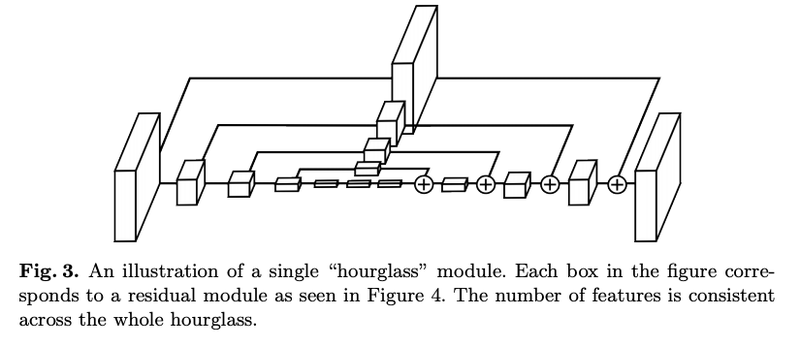

In [58]:
class BottleneckBlock(nn.Module):
    """
    Hourglass 용 BottleneckBlock
    """
    def __init__(self, in_channels, filters, stride=1, downsample=False):
        super(BottleneckBlock, self).__init__()
        self.downsample = downsample
        # 만약 downsample이라면 identity branch에 1x1 conv 적용하여 채널 수와 spatial size 조정
        if self.downsample:
            self.downsample_conv = nn.Conv2d(in_channels, filters, kernel_size=1, stride=stride, bias=False)

        # main branch
        self.bn1 = nn.BatchNorm2d(in_channels, momentum=0.9)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, filters // 2, kernel_size=1, stride=1, padding=0, bias=False)

        self.bn2 = nn.BatchNorm2d(filters // 2, momentum=0.9)
        # kernel_size=3, padding=1로 'same' padding 효과
        self.conv2 = nn.Conv2d(filters // 2, filters // 2, kernel_size=3, stride=stride, padding=1, bias=False)

        self.bn3 = nn.BatchNorm2d(filters // 2, momentum=0.9)
        self.conv3 = nn.Conv2d(filters // 2, filters, kernel_size=1, stride=1, padding=0, bias=False)

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample_conv(x)

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)

        out += identity
        return out
    
class HourglassModule(nn.Module):
    def __init__(self, order, filters, num_residual):
        super(HourglassModule, self).__init__()
        self.order = order

        # Up branch: BottleneckBlock 1회 + num_residual회 반복
        self.up1_0 = BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
        self.up1_blocks = nn.Sequential(*[
            BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
            for _ in range(num_residual)
        ])

        # Low branch: MaxPool + num_residual BottleneckBlock
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.low1_blocks = nn.Sequential(*[
            BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
            for _ in range(num_residual)
        ])

        # Recursive hourglass or additional BottleneckBlocks
        if order > 1:
            self.low2 = HourglassModule(order - 1, filters, num_residual)
        else:
            self.low2_blocks = nn.Sequential(*[
                BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
                for _ in range(num_residual)
            ])

        # 후처리 BottleneckBlock 반복
        self.low3_blocks = nn.Sequential(*[
            BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
            for _ in range(num_residual)
        ])

        # UpSampling (최근접 보간법)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        # up branch
        up1 = self.up1_0(x)
        up1 = self.up1_blocks(up1)

        # low branch
        low1 = self.pool(x)
        low1 = self.low1_blocks(low1)
        if self.order > 1:
            low2 = self.low2(low1)
        else:
            low2 = self.low2_blocks(low1)
        low3 = self.low3_blocks(low2)
        up2 = self.upsample(low3)

        return up2 + up1
    
class LinearLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LinearLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels, momentum=0.9)
        self.relu = nn.ReLU(inplace=True)

        # He (Kaiming) 초기화 적용
        nn.init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [60]:
class StackedHourglassNetwork(nn.Module):
    def __init__(self, input_shape=(256, 256, 3), num_stack=4, num_residual=1, num_heatmap=16):
        super(StackedHourglassNetwork, self).__init__()
        self.num_stack = num_stack

        in_channels = input_shape[2]  # 3
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=0.9)
        self.relu = nn.ReLU(inplace=True)

        # Bottleneck blocks 초기화
        # BottleneckBlock의 첫번째 호출: 64 → 128, downsample=True
        self.bottleneck1 = BottleneckBlock(in_channels=64, filters=128, stride=1, downsample=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 두 번째: 128 → 128, downsample=False
        self.bottleneck2 = BottleneckBlock(in_channels=128, filters=128, stride=1, downsample=False)
        # 세 번째: 128 → 256, downsample=True
        self.bottleneck3 = BottleneckBlock(in_channels=128, filters=256, stride=1, downsample=True)

        # 스택 구성 요소들
        self.hourglass_modules = nn.ModuleList()
        self.residual_modules = nn.ModuleList()  # hourglass 후 residual block들 (num_residual회)
        self.linear_layers = nn.ModuleList()
        self.heatmap_convs = nn.ModuleList()
        # 마지막 스택을 제외한 중간 피쳐 결합용 1x1 conv
        self.intermediate_convs = nn.ModuleList()
        self.intermediate_outs = nn.ModuleList()

        for i in range(num_stack):
            # order=4인 hourglass 모듈 (앞에서 정의한 HourglassModule 사용)
            self.hourglass_modules.append(HourglassModule(order=4, filters=256, num_residual=num_residual))
            # hourglass 후 residual block들
            self.residual_modules.append(nn.Sequential(*[
                BottleneckBlock(in_channels=256, filters=256, stride=1, downsample=False)
                for _ in range(num_residual)
            ]))
            # Linear layer: 1x1 conv + BN + ReLU (앞에서 정의한 LinearLayer 사용)
            self.linear_layers.append(LinearLayer(in_channels=256, out_channels=256))
            # 최종 heatmap을 생성하는 1x1 conv
            self.heatmap_convs.append(nn.Conv2d(256, num_heatmap, kernel_size=1, stride=1, padding=0))

            if i < num_stack - 1:
                self.intermediate_convs.append(nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0))
                self.intermediate_outs.append(nn.Conv2d(num_heatmap, 256, kernel_size=1, stride=1, padding=0))

    def forward(self, x):
        # x: (B, 3, H, W)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.bottleneck1(x)
        x = self.pool(x)
        x = self.bottleneck2(x)
        x = self.bottleneck3(x)

        outputs = []
        for i in range(self.num_stack):
            hg = self.hourglass_modules[i](x)
            res = self.residual_modules[i](hg)
            lin = self.linear_layers[i](res)
            heatmap = self.heatmap_convs[i](lin)
            outputs.append(heatmap)

            if i < self.num_stack - 1:
                inter1 = self.intermediate_convs[i](lin)
                inter2 = self.intermediate_outs[i](heatmap)
                x = inter1 + inter2  # 다음 스택의 입력으로 사용

        return outputs

---

## <a id='toc6_1_'></a>[6-1. 학습 엔진](#toc6_1_)

In [24]:
class StackedHourglassTrainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 initial_learning_rate,
                 heatmap_size=(64, 64),
                 distance_threshold=2.5):
        """
        - model: 학습시킬 PyTorch 모델(nn.Module)
        - epochs: 전체 학습 epoch 수
        - global_batch_size: 전체 배치 크기 (loss 계산 시 사용)
        - initial_learning_rate: 초기 학습률
        - heatmap_size: 히트맵 크기 (F1 score 계산용)
        - distance_threshold: F1 score 계산 시 허용 거리 (픽셀 단위)
        """
        self.model = model
        self.epochs = epochs
        self.global_batch_size = global_batch_size
        self.heatmap_size = heatmap_size
        self.distance_threshold = distance_threshold

        # MSE loss를 reduction='none'으로 사용 (가중치 적용을 위해)
        self.loss_object = nn.MSELoss(reduction='none')

        # Adam optimizer 초기화
        self.optimizer = optim.Adam(self.model.parameters(), lr=initial_learning_rate)

        # 학습률 스케줄링 관련 변수들
        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 4

        # 최적 모델 체크포인트 저장
        self.best_model = None

        # 단일 GPU/멀티 GPU(DataParallel) 설정
        if torch.cuda.device_count() > 1:
            print(f"멀티 GPU 사용 (GPU 개수: {torch.cuda.device_count()})")
            self.model = nn.DataParallel(self.model)
        else:
            print("단일 GPU 혹은 CPU 사용")

    def lr_decay(self):
        """
        patience_count가 max_patience를 넘으면 학습률을 1/10으로 감소,
        그렇지 않고 val_loss가 그대로면 patience_count += 1,
        새 최저 val_loss를 달성하면 patience_count를 0으로.
        """
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0

        self.patience_count += 1

        # optimizer의 learning rate 갱신
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.current_learning_rate

    def lr_decay_step(self, epoch):
        """
        25, 50, 75 epoch에서 학습률을 1/10으로 감소시키는 스케줄링.
        """
        if epoch in [25, 50, 75]:
            self.current_learning_rate /= 10.0

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        """
        여러 스택의 heatmap 출력(outputs)에 대해 MSE를 구하되,
        labels > 0인 위치에는 81의 추가 가중치를 적용.
        """
        loss = 0
        for output in outputs:
            # labels > 0 이면 81 + 1 = 82, 아니면 1
            weights = (labels > 0).float() * 81 + 1
            squared_error = (labels - output) ** 2
            weighted_error = squared_error * weights
            # 전체 배치에 대한 평균 후, global_batch_size로 나눔
            loss += weighted_error.mean() / self.global_batch_size
        return loss

    def compute_f1_score(self, labels, outputs):
        """
        F1 score 계산
        예측 좌표와 ground truth 좌표 간의 유클리드 거리가 threshold 이하이면 정답으로 간주

        Args:
            labels: ground truth heatmaps (B, C, H, W)
            outputs: predicted heatmaps (list of tensors or single tensor)

        Returns:
            f1_score: F1 score (평균 정확도)
        """
        # 마지막 스택의 출력 사용
        if isinstance(outputs, list):
            predictions = outputs[-1]
        else:
            predictions = outputs

        # predictions: (B, C, H, W), labels: (B, C, H, W)
        batch_size = labels.shape[0]
        num_keypoints = labels.shape[1]

        correct = 0
        total = 0

        for b in range(batch_size):
            for k in range(num_keypoints):
                # Ground truth에서 최대값 위치 찾기
                label_heatmap = labels[b, k]  # (H, W)
                label_flat = label_heatmap.reshape(-1)
                label_max_idx = torch.argmax(label_flat)
                label_y = label_max_idx // self.heatmap_size[1]
                label_x = label_max_idx % self.heatmap_size[1]

                # Ground truth가 유효한지 확인 (heatmap에 값이 있는지)
                label_max_value = label_heatmap[label_y, label_x]

                # Ground truth가 유효한 경우만 평가
                if label_max_value > 0:
                    # 예측에서 최대값 위치 찾기
                    pred_heatmap = predictions[b, k]  # (H, W)
                    pred_flat = pred_heatmap.reshape(-1)
                    pred_max_idx = torch.argmax(pred_flat)
                    pred_y = pred_max_idx // self.heatmap_size[1]
                    pred_x = pred_max_idx % self.heatmap_size[1]

                    # 유클리드 거리 계산
                    distance = torch.sqrt((pred_x - label_x).float() ** 2 + (pred_y - label_y).float() ** 2)
                    
                    total += 1
                    # 거리가 threshold 이하이면 정답
                    if distance <= self.distance_threshold:
                        correct += 1

        if total == 0:
            return 0.0

        return correct / total

    def train_step(self, images, labels, device):
        self.model.train()
        images = images.to(device)
        labels = labels.to(device)
        self.optimizer.zero_grad()
        outputs = self.model(images)
        loss = self.compute_loss(labels, outputs)
        loss.backward()
        self.optimizer.step()

        # F1 score 계산 (gradient 계산 없이)
        with torch.no_grad():
            f1 = self.compute_f1_score(labels, outputs)

        return loss.item(), f1

    def val_step(self, images, labels, device):
        self.model.eval()
        with torch.no_grad():
            images = images.to(device)
            labels = labels.to(device)
            outputs = self.model(images)
            loss = self.compute_loss(labels, outputs)
            f1 = self.compute_f1_score(labels, outputs)
            return loss.item(), f1

    def run(self, train_loader, val_loader, device):
        """
        - train_loader, val_loader: PyTorch DataLoader
        - device: torch.device('cuda' or 'cpu')
        """
        train_losses = []
        val_losses = []
        train_f1_scores = []
        val_f1_scores = []

        for epoch in range(1, self.epochs + 1):
            # 학습률 감소 로직
            self.lr_decay()
            print(f"Start epoch {epoch} with learning rate {self.current_learning_rate:.6f}")

            # ============= Training ===============
            total_train_loss = 0.0
            total_train_f1 = 0.0
            total_train_batches = len(train_loader)
            train_interval = max(1, total_train_batches//10)
            for batch_idx, (images, labels) in enumerate(train_loader, start=1):
                batch_loss, batch_f1 = self.train_step(images, labels, device)
                total_train_loss += batch_loss
                total_train_f1 += batch_f1
                if batch_idx % train_interval == 0 or batch_idx == total_train_batches:
                    avg_loss = total_train_loss/batch_idx
                    avg_f1 = total_train_f1/batch_idx
                    print(f"[Train] batch {batch_idx}/{total_train_batches} | batch_size {self.global_batch_size} | avg_loss {avg_loss:.4f} | avg_f1 {avg_f1:.4f}")
            train_loss = total_train_loss / total_train_batches
            train_f1 = total_train_f1 / total_train_batches
            train_losses.append(train_loss)
            train_f1_scores.append(train_f1)
            print(f"Epoch {epoch} train loss {train_loss:.4f} | train F1 {train_f1:.4f}")

            # ============== Validation ============
            total_val_loss = 0.0
            total_val_f1 = 0.0
            val_batches = 0
            total_val_batches = len(val_loader)
            val_interval = max(1, total_val_batches//10)

            for batch_idx, (images, labels) in enumerate(val_loader, start=1):
                batch_loss, batch_f1 = self.val_step(images, labels, device)
                if not math.isnan(batch_loss):
                    total_val_loss += batch_loss
                    total_val_f1 += batch_f1
                    val_batches += 1
                if batch_idx % val_interval == 0 or batch_idx == total_val_batches:
                    avg_loss = total_val_loss/val_batches if val_batches > 0 else 0.0
                    avg_f1 = total_val_f1/val_batches if val_batches > 0 else 0.0
                    print(f"[Val] batch {batch_idx}/{total_val_batches} | batch_size {self.global_batch_size} | avg_loss {avg_loss:.4f} | avg_f1 {avg_f1:.4f}")

            val_loss = total_val_loss / val_batches if val_batches > 0 else float('nan')
            val_f1 = total_val_f1 / val_batches if val_batches > 0 else 0.0
            val_losses.append(val_loss)
            val_f1_scores.append(val_f1)

            print(f"Epoch {epoch} val loss {val_loss:.4f} | val F1 {val_f1:.4f}")
            print("="*50)

            # 새로운 최저 val_loss 달성 시 모델 저장
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model, train_losses, val_losses, train_f1_scores, val_f1_scores

    def save_model(self, epoch, loss):
        model_name = os.path.join(MODEL_PATH, f'[HourglassModel] epoch-{epoch}-loss-{loss:.4f}.pt')
        torch.save(self.model.state_dict(), model_name)
        self.best_model = model_name
        print(f"Model {model_name} saved.")

In [25]:
def create_dataloader(annotation_file, image_dir, batch_size, num_heatmap, is_train=True):
    """
    annotation_file: JSON 파일 경로 (예: train.json)
    image_dir: 이미지 파일들이 저장된 디렉토리 경로
    batch_size: 배치 크기
    num_heatmap: 생성할 heatmap 개수
    is_train: True이면 shuffle 적용
    """

    preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap),
        is_train=is_train
    )

    dataset = MPIIDataset(annotation_file=annotation_file, image_dir=image_dir, transform=preprocess)

    # DataLoader 생성
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=is_train,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
        prefetch_factor=2
    )

    return dataloader

In [26]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_annotation_file, val_annotation_file, image_dir):
    """
    - epochs: 전체 학습 epoch 수
    - learning_rate: 초기 학습률
    - num_heatmap: 생성할 heatmap 개수
    - batch_size: 배치 크기
    - train_annotation_file: train.json 파일 경로
    - val_annotation_file: validation.json 파일 경로
    - image_dir: 이미지 파일들이 저장된 디렉토리 경로
    """
    global_batch_size = batch_size

    train_loader = create_dataloader(train_annotation_file, image_dir, batch_size, num_heatmap, is_train=True)
    val_loader = create_dataloader(val_annotation_file, image_dir, batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    model = StackedHourglassNetwork(IMAGE_SHAPE, num_stack=4, num_residual=1, num_heatmap=num_heatmap)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    trainer = StackedHourglassTrainer(
        model,
        epochs,
        global_batch_size,
        initial_learning_rate=learning_rate,
        heatmap_size=HEATMAP_SIZE
    )

    print("Start training...")
    return trainer.run(train_loader, val_loader, device)

In [27]:
hourglass_best_model, hourglass_train_losses, hourglass_val_losses, hourglass_train_f1_scores, hourglass_val_f1_scores \
    = train(
            EPOCHS, 
            LEARNING_RATE, 
            NUM_HEATMAP, 
            TRAIN_BATCH_SIZE, 
            TRAIN_JSON, 
            VALID_JSON, 
            IMAGE_PATH
            )

단일 GPU 혹은 CPU 사용
Start training...
Start epoch 1 with learning rate 0.000700
[Train] batch 139/1391 | batch_size 16 | avg_loss 1.6440 | avg_f1 0.0949
[Train] batch 278/1391 | batch_size 16 | avg_loss 1.5761 | avg_f1 0.1244
[Train] batch 417/1391 | batch_size 16 | avg_loss 1.5351 | avg_f1 0.1520
[Train] batch 556/1391 | batch_size 16 | avg_loss 1.5052 | avg_f1 0.1763
[Train] batch 695/1391 | batch_size 16 | avg_loss 1.4801 | avg_f1 0.1970
[Train] batch 834/1391 | batch_size 16 | avg_loss 1.4603 | avg_f1 0.2140
[Train] batch 973/1391 | batch_size 16 | avg_loss 1.4435 | avg_f1 0.2301
[Train] batch 1112/1391 | batch_size 16 | avg_loss 1.4274 | avg_f1 0.2436
[Train] batch 1251/1391 | batch_size 16 | avg_loss 1.4131 | avg_f1 0.2561
[Train] batch 1390/1391 | batch_size 16 | avg_loss 1.4009 | avg_f1 0.2688
[Train] batch 1391/1391 | batch_size 16 | avg_loss 1.4007 | avg_f1 0.2690
Epoch 1 train loss 1.4007 | train F1 0.2690
[Val] batch 18/185 | batch_size 16 | avg_loss 1.2826 | avg_f1 0.3989
[Va

---

## <a id='toc6_2_'></a>[6-2. 예측 엔진 만들기](#toc6_2_)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StackedHourglassNetwork(IMAGE_SHAPE, num_stack=4, num_residual=1, num_heatmap=NUM_HEATMAP)
model.to(device)
checkpoint = torch.load(hourglass_best_model, map_location=device)
model.load_state_dict(checkpoint)
model.eval()

/tmp/ipykernel_297964/938632109.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(hourglass_best_model, map_location=device)


StackedHourglassNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (bottleneck1): BottleneckBlock(
    (downsample_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck2

In [29]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

In [30]:
def find_max_coordinates(heatmaps):
    """
    입력으로 받은 heatmap에서 각 keypoint의 가장 확률이 높은 좌표를 찾는 함수
    heatmap에서 가장 큰 값을 가지는 좌표를 반환
    """
    # heatmaps: (H, W, C)
    H, W, C = heatmaps.shape
    # reshape to (H*W, C)
    flatten_heatmaps = heatmaps.reshape(-1, C)
    # 각 채널 별 최대값 인덱스 (flattened index)
    indices = torch.argmax(flatten_heatmaps, dim=0)
    # y 좌표: index // H, x 좌표: index - H * y
    y = indices // H
    x = indices - H * y
    # 반환: (C, 2) 텐서, 각 행이 [x, y] 좌표
    return torch.stack([x, y], dim=1)

def extract_keypoints_from_heatmap(heatmaps):
    """
    find_max_coordinates로 최댓값 위치를 찾고 정수 좌표를 실수 좌표로 변환하여 더 정밀한 관절 위치 추정
    이후 정규화된 좌표 반환
    heatmaps: (H, W, C) 텐서 (예: (64,64,16))
    """
    H, W, C = heatmaps.shape
    max_keypoints = find_max_coordinates(heatmaps)  # shape: (C, 2) with [x, y] per channel

    # pad heatmaps: 먼저 (C, H, W)로 변환한 후 pad, 다시 (H+2, W+2, C)
    heatmaps_permuted = heatmaps.permute(2, 0, 1)  # (C, H, W)
    padded = F.pad(heatmaps_permuted, (1, 1, 1, 1))  # pad (left, right, top, bottom)
    padded_heatmaps = padded.permute(1, 2, 0)  # (H+2, W+2, C)

    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        # 기존 keypoint의 좌표에 패딩 오프셋 추가
        max_x = int(keypoint[0].item()) + 1
        max_y = int(keypoint[1].item()) + 1

        # 3x3 패치를 추출 (채널 i)
        patch = padded_heatmaps[max_y-1:max_y+2, max_x-1:max_x+2, i]  # (3,3)
        # 중앙 값 제거
        patch[1, 1] = 0
        # 패치 내 최대값의 index를 찾음
        flat_patch = patch.reshape(-1)
        index = torch.argmax(flat_patch).item()

        next_y = index // 3
        next_x = index % 3
        delta_y = (next_y - 1) / 4.0
        delta_x = (next_x - 1) / 4.0

        adjusted_x = keypoint[0].item() + delta_x
        adjusted_y = keypoint[1].item() + delta_y
        adjusted_keypoints.append((adjusted_x, adjusted_y))

    # 리스트를 텐서로 변환하고 clip
    adjusted_keypoints = torch.tensor(adjusted_keypoints)
    adjusted_keypoints = torch.clamp(adjusted_keypoints, 0, H)
    normalized_keypoints = adjusted_keypoints / H
    return normalized_keypoints

In [31]:
def predict(model, image_path):
    """
    이미지를 로드하고 전처리한 후 모델을 통해 inference 진행 후 extract_kkeypoints_from_heatmap()함수를
    이용하여 좌표를 계산하고 원본 이미지와 함게 좌표 반환
    """
    # 이미지 로드 (RGB 모드)
    image = Image.open(image_path).convert("RGB")

    # 전처리: 리사이즈, 텐서 변환, [-1, 1] 범위로 스케일링
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),         # 결과: [0, 1]
        transforms.Lambda(lambda x: x * 2 - 1)  # [0,1] -> [-1,1]
    ])
    inputs = preprocess(image)          # shape: (C, H, W)
    inputs = inputs.unsqueeze(0)        # 배치 차원 추가: (1, C, H, W)

    # 모델의 device에 맞게 입력을 이동시킵니다.
    device = next(model.parameters()).device
    inputs = inputs.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(inputs)         # outputs가 리스트가 아닐 수 있음

    if not isinstance(outputs, list):
        outputs = [outputs]

    # 마지막 스택의 결과를 사용한다고 가정 (출력 shape: (1, num_heatmap, H, W))
    heatmap_tensor = outputs[-1].squeeze(0)      # (num_heatmap, H, W)
    # extract_keypoints_from_heatmap 함수는 (H, W, num_heatmap) 형태를 기대하므로 차원 순서를 변경
    heatmap_tensor = heatmap_tensor.permute(1, 2, 0)  # (H, W, num_heatmap)

    # detach, CPU로 이동 후 extract_keypoints_from_heatmap에 전달
    heatmap = heatmap_tensor.detach().cpu()
    kp = extract_keypoints_from_heatmap(heatmap)

    return image, kp


In [32]:
def to_numpy_image(image):
    """
    image에 좌표를 찍기 위해 image를 numpy로 변환하여 반환
    """
    if torch.is_tensor(image):
        image_np = image.detach().cpu().numpy()
        # 이미지 채널이 첫 번째 차원이라면, (C, H, W) -> (H, W, C)
        if image_np.ndim == 3 and image_np.shape[0] == 3:
            image_np = np.transpose(image_np, (1, 2, 0))
    elif not isinstance(image, np.ndarray):
        # PIL.Image인 경우
        image_np = np.array(image)
    else:
        image_np = image
    return image_np

def draw_keypoints_on_image(image, keypoints, index=None, ax=None):
    image_np = to_numpy_image(image)

    if ax is None:
        fig, ax = plt.subplots(1)
        show_plot = True
    else:
        show_plot = False

    ax.imshow(image_np)
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image_np.shape[1]
        joint_y = joint[1] * image_np.shape[0]
        if index is not None and index != i:
            continue
        ax.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    
    if show_plot:
        plt.show()
    
    return ax

def draw_skeleton_on_image(image, keypoints, index=None, ax=None):
    image_np = to_numpy_image(image)

    if ax is None:
        fig, ax = plt.subplots(1)
        show_plot = True
    else:
        show_plot = False

    ax.imshow(image_np)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image_np.shape[1]
        joint_y = joint[1] * image_np.shape[0]
        joints.append((joint_x, joint_y))

    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        ax.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    
    if show_plot:
        plt.show()
    
    return ax


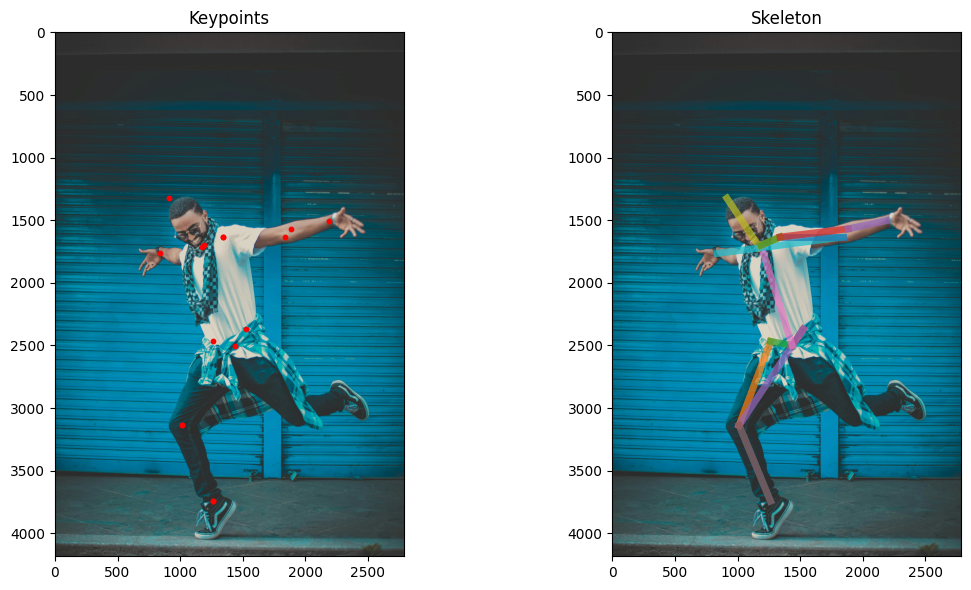

In [ ]:
test_image = os.path.join(DATA_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

draw_keypoints_on_image(image, keypoints, ax=axes[0])
axes[0].set_title('Keypoints')
draw_skeleton_on_image(image, keypoints, ax=axes[1])
axes[1].set_title('Skeleton')

plt.tight_layout()
plt.show()


---

# <a id='toc7_'></a>[7. SimpleBaseline 모델 만들기](#toc7_)

In [63]:
class ResNetBottleneckBlock(nn.Module):
    """ResNet의 Bottleneck Block"""
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResNetBottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, 
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class SimpleBaseline(nn.Module):
    """
    SimpleBaseline 모델
    - ResNet50을 backbone으로 사용
    - Deconvolution layers로 upsampling하여 heatmap 생성
    """
    
    def __init__(self, 
                 input_shape=(256, 256, 3), 
                 num_heatmap=16, 
                 num_deconv_layers=3, 
                 num_deconv_filters=[256, 256, 256], 
                 num_deconv_kernels=[4, 4, 4]):
        super(SimpleBaseline, self).__init__()
        
        self.in_channels = 64
        in_ch = input_shape[2]  # 3
        
        # ResNet50 Backbone (초기 레이어)
        self.conv1 = nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # ResNet50 Layers (Bottleneck 사용)
        self.layer1 = self._make_layer(ResNetBottleneckBlock, 64, 3)
        self.layer2 = self._make_layer(ResNetBottleneckBlock, 128, 4, stride=2)
        self.layer3 = self._make_layer(ResNetBottleneckBlock, 256, 6, stride=2)
        self.layer4 = self._make_layer(ResNetBottleneckBlock, 512, 3, stride=2)
        
        # Deconvolution layers (upsampling)
        self.deconv_layers = self._make_deconv_layers(
            num_deconv_layers,
            num_deconv_filters,
            num_deconv_kernels
        )
        
        # 최종 heatmap 생성 (1x1 conv)
        self.final_layer = nn.Conv2d(
            in_channels=num_deconv_filters[-1],
            out_channels=num_heatmap,
            kernel_size=1,
            stride=1,
            padding=0
        )
        
        # 가중치 초기화
        self._init_weights()
    
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def _make_deconv_layers(self, num_layers, num_filters, num_kernels):
        """
        Transpose Convolution 레이어 생성
        """
        layers = []
        in_channels = 2048  # ResNet50의 마지막 출력 채널 수
        
        for i in range(num_layers):
            # ConvTranspose2d: kernel_size=4, stride=2, padding=1 -> 2배 upsampling
            layers.append(
                nn.ConvTranspose2d(
                    in_channels=in_channels,
                    out_channels=num_filters[i],
                    kernel_size=num_kernels[i],
                    stride=2,
                    padding=1,
                    output_padding=0,
                    bias=False
                )
            )
            layers.append(nn.BatchNorm2d(num_filters[i]))
            layers.append(nn.ReLU(inplace=True))
            in_channels = num_filters[i]
        
        return nn.Sequential(*layers)
    
    def _init_weights(self):
        """가중치 초기화"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, std=0.001)
    
    def forward(self, x):
        # ResNet Backbone
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Deconvolution layers
        x = self.deconv_layers(x)
        # Final heatmap
        x = self.final_layer(x)
        
        return x

---

## <a id='toc7_1_'></a>[7-1. SimpleBaseline 학습 엔진](#toc0_)

In [39]:
class SimpleBaselineTrainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 initial_learning_rate,
                 heatmap_size=(64, 64),
                 distance_threshold=2.5):
        """
        - model: 학습시킬 PyTorch 모델(nn.Module)
        - epochs: 전체 학습 epoch 수
        - global_batch_size: 전체 배치 크기 (loss 계산 시 사용)
        - initial_learning_rate: 초기 학습률
        - heatmap_size: 히트맵 크기 (F1 score 계산용)
        - distance_threshold: F1 score 계산 시 허용 거리 (픽셀 단위)
        """
        self.model = model
        self.epochs = epochs
        self.global_batch_size = global_batch_size
        self.heatmap_size = heatmap_size
        self.distance_threshold = distance_threshold

        # MSE loss를 reduction='none'으로 사용 (가중치 적용을 위해)
        self.loss_object = nn.MSELoss(reduction='none')

        # Adam optimizer 초기화
        self.optimizer = optim.Adam(self.model.parameters(), lr=initial_learning_rate)

        # 학습률 스케줄링 관련 변수들
        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 5

        # 최적 모델 체크포인트 저장
        self.best_model = None

        # 단일 GPU/멀티 GPU(DataParallel) 설정
        if torch.cuda.device_count() > 1:
            print(f"멀티 GPU 사용 (GPU 개수: {torch.cuda.device_count()})")
            self.model = nn.DataParallel(self.model)
        else:
            print("단일 GPU 혹은 CPU 사용")

    def lr_decay(self):
        """
        patience_count가 max_patience를 넘으면 학습률을 1/10으로 감소,
        그렇지 않고 val_loss가 그대로면 patience_count += 1,
        새 최저 val_loss를 달성하면 patience_count를 0으로.
        """
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0

        self.patience_count += 1

        # optimizer의 learning rate 갱신
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.current_learning_rate

    def compute_loss(self, labels, output):
        """
        SimpleBaseline은 단일 heatmap 출력만 있음
        labels > 0인 위치에는 81의 추가 가중치를 적용.
        """
        # labels > 0 이면 81 + 1 = 82, 아니면 1
        weights = (labels > 0).float() * 81 + 1
        squared_error = (labels - output) ** 2
        weighted_error = squared_error * weights
        # 전체 배치에 대한 평균 후, global_batch_size로 나눔
        loss = weighted_error.mean() / self.global_batch_size
        return loss

    def compute_f1_score(self, labels, output):
        """
        F1 score 계산
        예측 좌표와 ground truth 좌표 간의 유클리드 거리가 threshold 이하이면 정답으로 간주

        Args:
            labels: ground truth heatmaps (B, C, H, W)
            output: predicted heatmaps (B, C, H, W)

        Returns:
            f1_score: F1 score (평균 정확도)
        """
        # output: (B, C, H, W), labels: (B, C, H, W)
        batch_size = labels.shape[0]
        num_keypoints = labels.shape[1]

        correct = 0
        total = 0

        for b in range(batch_size):
            for k in range(num_keypoints):
                # Ground truth에서 최대값 위치 찾기
                label_heatmap = labels[b, k]  # (H, W)
                label_flat = label_heatmap.reshape(-1)
                label_max_idx = torch.argmax(label_flat)
                label_y = label_max_idx // self.heatmap_size[1]
                label_x = label_max_idx % self.heatmap_size[1]

                # Ground truth가 유효한지 확인 (heatmap에 값이 있는지)
                label_max_value = label_heatmap[label_y, label_x]

                # Ground truth가 유효한 경우만 평가
                if label_max_value > 0:
                    # 예측에서 최대값 위치 찾기
                    pred_heatmap = output[b, k]  # (H, W)
                    pred_flat = pred_heatmap.reshape(-1)
                    pred_max_idx = torch.argmax(pred_flat)
                    pred_y = pred_max_idx // self.heatmap_size[1]
                    pred_x = pred_max_idx % self.heatmap_size[1]

                    # 유클리드 거리 계산
                    distance = torch.sqrt((pred_x - label_x).float() ** 2 + (pred_y - label_y).float() ** 2)
                    
                    total += 1
                    # 거리가 threshold 이하이면 정답
                    if distance <= self.distance_threshold:
                        correct += 1

        if total == 0:
            return 0.0

        return correct / total

    def train_step(self, images, labels, device):
        self.model.train()
        images = images.to(device)
        labels = labels.to(device)

        self.optimizer.zero_grad()
        output = self.model(images)
        loss = self.compute_loss(labels, output)
        loss.backward()
        self.optimizer.step()

        # F1 score 계산 (gradient 계산 없이)
        with torch.no_grad():
            f1 = self.compute_f1_score(labels, output)

        return loss.item(), f1

    def val_step(self, images, labels, device):
        self.model.eval()
        with torch.no_grad():
            images = images.to(device)
            labels = labels.to(device)
            output = self.model(images)
            loss = self.compute_loss(labels, output)
            f1 = self.compute_f1_score(labels, output)
        return loss.item(), f1

    def run(self, train_loader, val_loader, device):
        """
        - train_loader, val_loader: PyTorch DataLoader
        - device: torch.device('cuda' or 'cpu')
        """
        train_losses = []
        val_losses = []
        train_f1_scores = []
        val_f1_scores = []

        for epoch in range(1, self.epochs + 1):
            # 학습률 감소 로직
            self.lr_decay()
            print(f"Start epoch {epoch} with learning rate {self.current_learning_rate:.6f}")

            # ============= Training ===============
            total_train_loss = 0.0
            total_train_f1 = 0.0
            total_train_batches = len(train_loader)
            train_interval = max(1, total_train_batches//10)
            for batch_idx, (images, labels) in enumerate(train_loader, start=1):
                batch_loss, batch_f1 = self.train_step(images, labels, device)
                total_train_loss += batch_loss
                total_train_f1 += batch_f1
                if batch_idx % train_interval == 0 or batch_idx == total_train_batches:
                    avg_loss = total_train_loss/batch_idx
                    avg_f1 = total_train_f1/batch_idx
                    print(f"[Train] batch {batch_idx}/{total_train_batches} | batch_size {self.global_batch_size} | avg_loss {avg_loss:.4f} | avg_f1 {avg_f1:.4f}")
            train_loss = total_train_loss / total_train_batches
            train_f1 = total_train_f1 / total_train_batches
            train_losses.append(train_loss)
            train_f1_scores.append(train_f1)
            print(f"Epoch {epoch} train loss {train_loss:.4f} | train F1 {train_f1:.4f}")

            # ============== Validation ============
            total_val_loss = 0.0
            total_val_f1 = 0.0
            val_batches = 0
            total_val_batches = len(val_loader)
            val_interval = max(1, total_val_batches//10)

            for batch_idx, (images, labels) in enumerate(val_loader, start=1):
                batch_loss, batch_f1 = self.val_step(images, labels, device)
                if not math.isnan(batch_loss):
                    total_val_loss += batch_loss
                    total_val_f1 += batch_f1
                    val_batches += 1
                if batch_idx % val_interval == 0 or batch_idx == total_val_batches:
                    avg_loss = total_val_loss/val_batches if val_batches > 0 else 0.0
                    avg_f1 = total_val_f1/val_batches if val_batches > 0 else 0.0
                    print(f"[Val] batch {batch_idx}/{total_val_batches} | batch_size {self.global_batch_size} | avg_loss {avg_loss:.4f} | avg_f1 {avg_f1:.4f}")

            val_loss = total_val_loss / val_batches if val_batches > 0 else float('nan')
            val_f1 = total_val_f1 / val_batches if val_batches > 0 else 0.0
            val_losses.append(val_loss)
            val_f1_scores.append(val_f1)

            print(f"Epoch {epoch} val loss {val_loss:.4f} | val F1 {val_f1:.4f}")
            print("="*50)

            # 새로운 최저 val_loss 달성 시 모델 저장
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model, train_losses, val_losses, train_f1_scores, val_f1_scores

    def save_model(self, epoch, loss):
        model_name = os.path.join(MODEL_PATH, f'[SimpleBaseline] epoch-{epoch}-loss-{loss:.4f}.pt')
        torch.save(self.model.state_dict(), model_name)
        self.best_model = model_name
        print(f"Model {model_name} saved.")

In [40]:
def train_simplebaseline(epochs, learning_rate, num_heatmap, batch_size, 
                         train_annotation_file, val_annotation_file, image_dir):
    """
    SimpleBaseline 모델 학습 함수
    create_dataloader() 함수를 재사용하여 데이터 로더 생성
    """
    global_batch_size = batch_size

    # 기존의 create_dataloader 함수 재사용
    train_loader = create_dataloader(train_annotation_file, image_dir, batch_size, num_heatmap, is_train=True)
    val_loader = create_dataloader(val_annotation_file, image_dir, batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    # SimpleBaseline 모델 생성
    model = SimpleBaseline(IMAGE_SHAPE, num_heatmap=num_heatmap)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # SimpleBaseline 전용 Trainer 사용
    trainer = SimpleBaselineTrainer(
        model,
        epochs,
        global_batch_size,
        initial_learning_rate=learning_rate,
        heatmap_size=HEATMAP_SIZE
    )

    print("Start training SimpleBaseline...")
    return trainer.run(train_loader, val_loader, device)

In [41]:
simplebaseline_best_model, simplebaseline_train_losses, simplebaseline_val_losses, simplebaseline_train_f1_scores, simplebaseline_val_f1_scores \
    = train_simplebaseline(
            EPOCHS, 
            LEARNING_RATE, 
            NUM_HEATMAP, 
            TRAIN_BATCH_SIZE, 
            TRAIN_JSON, 
            VALID_JSON, 
            IMAGE_PATH
        )

단일 GPU 혹은 CPU 사용
Start training SimpleBaseline...
Start epoch 1 with learning rate 0.000700
[Train] batch 139/1391 | batch_size 16 | avg_loss 0.7719 | avg_f1 0.0023
[Train] batch 278/1391 | batch_size 16 | avg_loss 0.6146 | avg_f1 0.0016
[Train] batch 417/1391 | batch_size 16 | avg_loss 0.5609 | avg_f1 0.0017
[Train] batch 556/1391 | batch_size 16 | avg_loss 0.5314 | avg_f1 0.0035
[Train] batch 695/1391 | batch_size 16 | avg_loss 0.5116 | avg_f1 0.0063
[Train] batch 834/1391 | batch_size 16 | avg_loss 0.4970 | avg_f1 0.0099
[Train] batch 973/1391 | batch_size 16 | avg_loss 0.4848 | avg_f1 0.0153
[Train] batch 1112/1391 | batch_size 16 | avg_loss 0.4751 | avg_f1 0.0217
[Train] batch 1251/1391 | batch_size 16 | avg_loss 0.4670 | avg_f1 0.0280
[Train] batch 1390/1391 | batch_size 16 | avg_loss 0.4599 | avg_f1 0.0337
[Train] batch 1391/1391 | batch_size 16 | avg_loss 0.4599 | avg_f1 0.0337
Epoch 1 train loss 0.4599 | train F1 0.0337
[Val] batch 18/185 | batch_size 16 | avg_loss 1.1686 | av

---

## <a id='toc7_2_'></a>[7-2. SimpleBaseline 예측 엔진](#toc7_2)

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleBaseline(IMAGE_SHAPE, num_heatmap=NUM_HEATMAP)
model.to(device)
checkpoint = torch.load(simplebaseline_best_model, map_location=device)
model.load_state_dict(checkpoint)
model.eval()

/tmp/ipykernel_297964/1334733176.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(simplebaseline_best_model, map_location=device)


SimpleBaseline(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BottleneckBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1)

In [44]:
def predict_simplebaseline(model, image_path):
    """
    SimpleBaseline 모델 예측 함수
    기존 predict 함수와 동일하지만 SimpleBaseline은 단일 output만 반환
    """
    # 이미지 로드 (RGB 모드)
    image = Image.open(image_path).convert("RGB")

    # 전처리: 리사이즈, 텐서 변환, [-1, 1] 범위로 스케일링
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),         # 결과: [0, 1]
        transforms.Lambda(lambda x: x * 2 - 1)  # [0,1] -> [-1,1]
    ])
    inputs = preprocess(image)          # shape: (C, H, W)
    inputs = inputs.unsqueeze(0)        # 배치 차원 추가: (1, C, H, W)

    # 모델의 device에 맞게 입력을 이동시킵니다.
    device = next(model.parameters()).device
    inputs = inputs.to(device)

    model.eval()
    with torch.no_grad():
        output = model(inputs)  # SimpleBaseline은 단일 텐서 반환
    
    # 출력 shape: (1, num_heatmap, H, W)
    heatmap_tensor = output.squeeze(0)  # (num_heatmap, H, W)
    
    # extract_keypoints_from_heatmap 함수는 (H, W, num_heatmap) 형태를 기대하므로 차원 순서를 변경
    heatmap_tensor = heatmap_tensor.permute(1, 2, 0)  # (H, W, num_heatmap)

    # detach, CPU로 이동 후 extract_keypoints_from_heatmap에 전달
    heatmap = heatmap_tensor.detach().cpu()
    kp = extract_keypoints_from_heatmap(heatmap)

    return image, kp

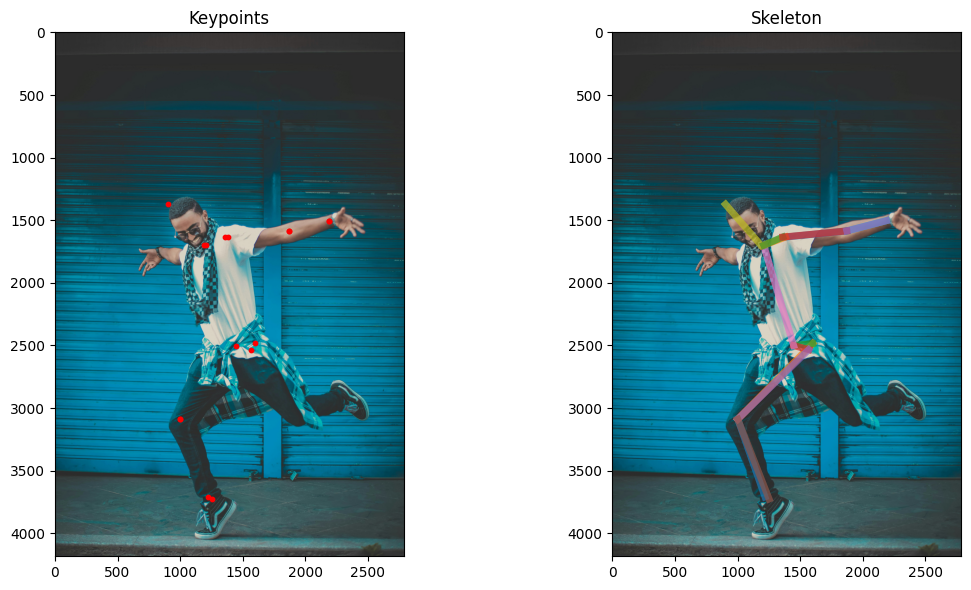

In [45]:
test_image = os.path.join(DATA_PATH, 'test_image.jpg')

image, keypoints = predict_simplebaseline(model, test_image)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

draw_keypoints_on_image(image, keypoints, ax=axes[0])
axes[0].set_title('Keypoints')
draw_skeleton_on_image(image, keypoints, ax=axes[1])
axes[1].set_title('Skeleton')

plt.tight_layout()
plt.show()

---

# <a id='toc8_'></a>[8. 모델 예측 및 비교](#toc8_)

## <a id='toc8_1_'></a>[8-1. loss 비교](#toc8_1_)

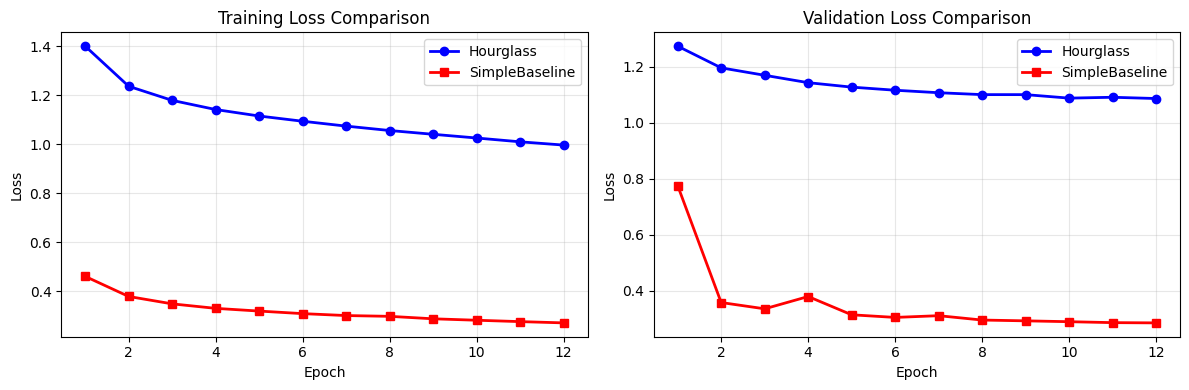

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
epochs = range(1, EPOCHS+1)

# Train Loss 비교
axes[0].plot(epochs, hourglass_train_losses, 'b-o', label='Hourglass', linewidth=2, markersize=6)
axes[0].plot(epochs, simplebaseline_train_losses, 'r-s', label='SimpleBaseline', linewidth=2, markersize=6)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation Loss 비교
axes[1].plot(epochs, hourglass_val_losses, 'b-o', label='Hourglass', linewidth=2, markersize=6)
axes[1].plot(epochs, simplebaseline_val_losses, 'r-s', label='SimpleBaseline', linewidth=2, markersize=6)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Validation Loss Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## <a id='toc8_2_'></a>[8-2. f1-score 비교](#toc8_2_)

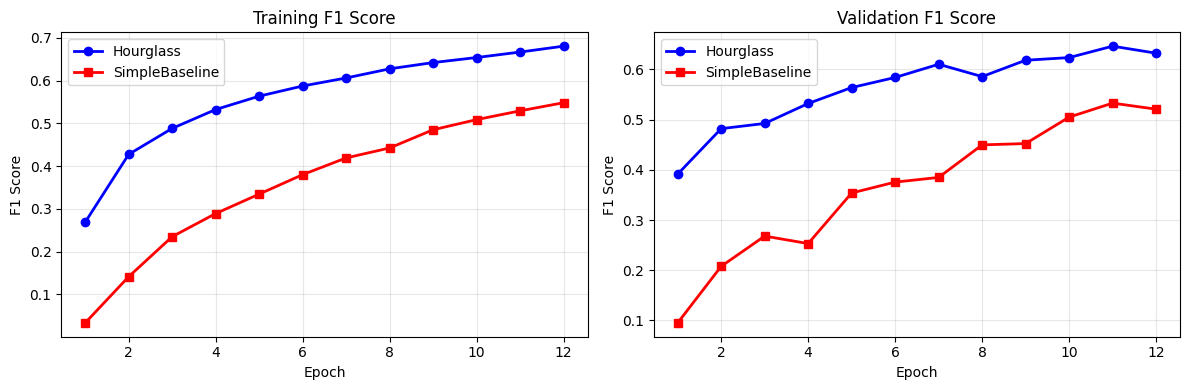

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
epochs = range(1, EPOCHS+1)

# Train F1 Score 비교
axes[0].plot(epochs, hourglass_train_f1_scores, 'b-o', label='Hourglass', linewidth=2, markersize=6)
axes[0].plot(epochs, simplebaseline_train_f1_scores, 'r-s', label='SimpleBaseline', linewidth=2, markersize=6)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('Training F1 Score')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation F1 Score 비교
axes[1].plot(epochs, hourglass_val_f1_scores, 'b-o', label='Hourglass', linewidth=2, markersize=6)
axes[1].plot(epochs, simplebaseline_val_f1_scores, 'r-s', label='SimpleBaseline', linewidth=2, markersize=6)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Validation F1 Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## <a id='toc8_3_'></a>[8-3. test.jpg 비교](#toc8_3_)

In [67]:
BEST_STACKED_HOURGLASS_PATH = os.path.join(DATA_PATH, "models/[HourglassModel] epoch-12-loss-1.0866.pt")
BEST_SIMPLE_BASELINE_PATH = os.path.join(DATA_PATH, "models/[SimpleBaseline] epoch-12-loss-0.2848.pt")

In [68]:
# StackedHourglass model 불러오기
hourglass_model = StackedHourglassNetwork(IMAGE_SHAPE, num_heatmap=NUM_HEATMAP)
hourglass_model.to(device)
checkpoint = torch.load(BEST_STACKED_HOURGLASS_PATH, map_location=device)
hourglass_model.load_state_dict(checkpoint)
hourglass_model.eval()

# SimpleBaseline model 불러오기
baseline_model = SimpleBaseline(IMAGE_SHAPE, num_heatmap=NUM_HEATMAP)
baseline_model.to(device)
checkpoint = torch.load(BEST_SIMPLE_BASELINE_PATH, map_location=device)
baseline_model.load_state_dict(checkpoint)
baseline_model.eval()

/tmp/ipykernel_297964/648295357.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(BEST_STACKED_HOURGLASS_PATH, map_location=device)
/tmp/ipykernel_

SimpleBaseline(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBottleneckBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=

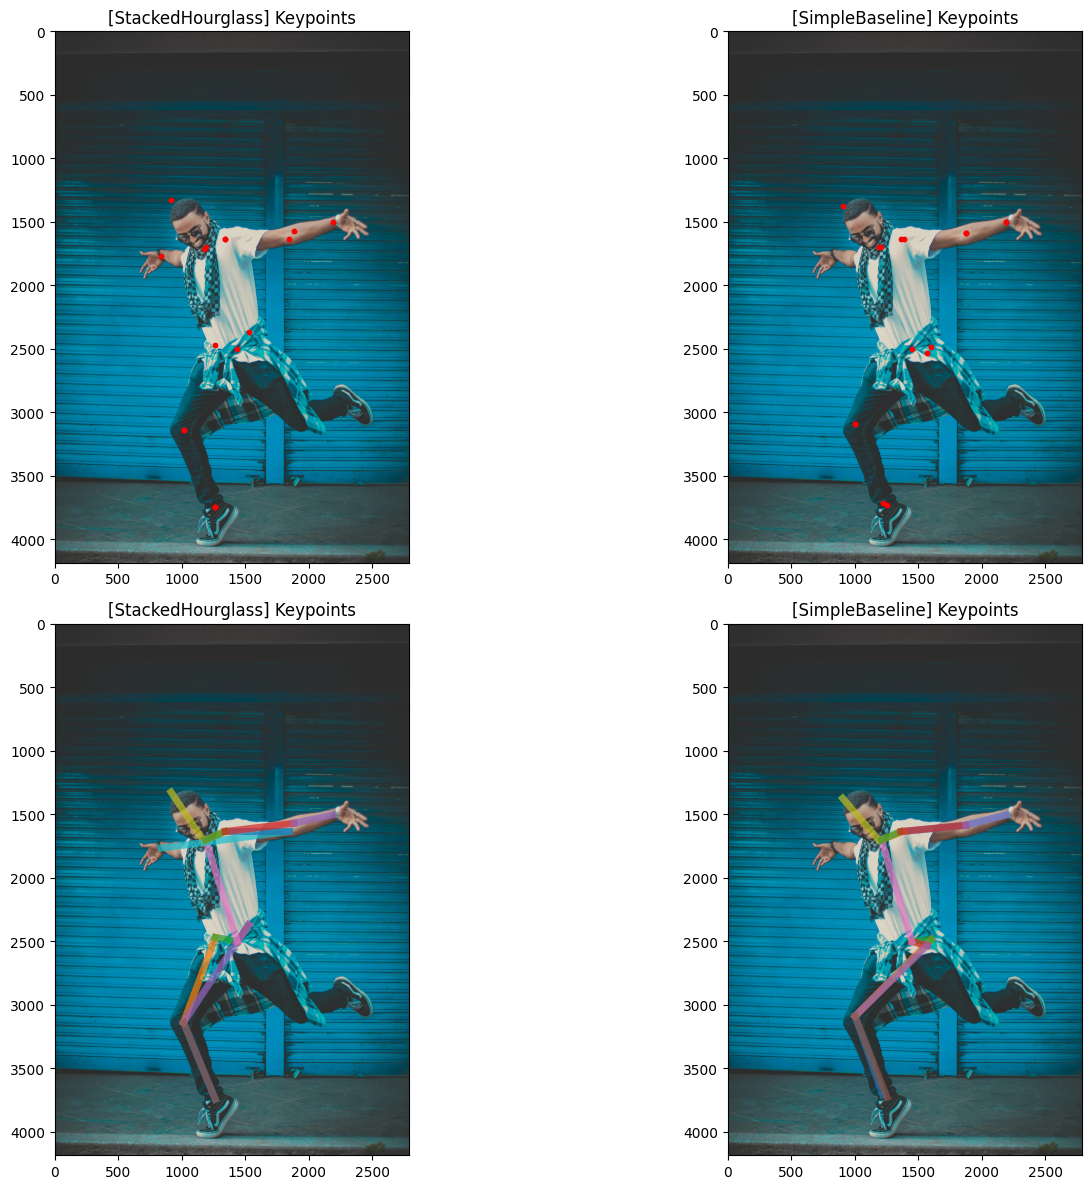

In [69]:
test_image = os.path.join(DATA_PATH, 'test_image.jpg')

image, hour_keypoints = predict(hourglass_model, test_image)
image, simple_keypoints = predict_simplebaseline(baseline_model, test_image)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

draw_keypoints_on_image(image, hour_keypoints, ax=axes[0][0])
axes[0][0].set_title('[StackedHourglass] Keypoints')
draw_keypoints_on_image(image, simple_keypoints, ax=axes[0][1])
axes[0][1].set_title('[SimpleBaseline] Keypoints')

draw_skeleton_on_image(image, hour_keypoints, ax=axes[1][0])
axes[1][0].set_title('[StackedHourglass] Keypoints')
draw_skeleton_on_image(image, simple_keypoints, ax=axes[1][1])
axes[1][1].set_title('[SimpleBaseline] Keypoints')


plt.tight_layout()
plt.show()

---

# <a id='toc9_'></a>[9. 회고](#toc9_)

**f1 score의 의미**
먼저 confusion matrix에서 각각의 변수 TP, FN, FP가 무엇을 의미하는 지 알아야 한다.
- TP : keypoint가 보이고 + 정확하게 예측 (<= threshold)
- FN : keypoint가 보이지만 + 부정확하게 예측 (>= threshold)
- FP : keypoint가 없는데 + 예측 -> 항상 0
- TN : keypoint가 없고 + 예측도 안함 -> 항상 0 
- F1 Score = 2 × (Precision × Recall) / (Precision + Recall)
- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN)
사실 해당 task에서는 FP가 발생할 수 없다. FP의 정의는 "실제로는 없는데 있다고 예측한 것"이다. 이 task에서는 모든 이미지가 16개의 keypoint를 가진다. 각 채널에서 정확히 1개의 좌표를 argmax로 추출하기 때문에 "없는 keypoint"라는 개념 자체가 없다.  
따라서 Precision은 1이 된다.. 따라서 해당 코드에서 사용한 f1 score는 사실 recall이다.  
  
threshold를 2.5로 두었는데 heatmap이 (64x64) 이므로 원본 이미지 크기인 (256x256) 으로 환산하면 10 px 정도가 된다.  
즉, 10px 이내로 예측을 했다면 TP로 취급했다.  
  
고민이 되었던 거는 hourglass model에 비해 simplebaseline model이 loss가 더 낮은데, f1 score(=recall)이 더 낮게 나왔다는 점이다.  
이 부분은... 아마 heatmap의 개형은 simplebaseline model이 더 잘 그렸고 heatmap이 겹친 부분자체는 더 많지만 center가 멀리 있기 때문이 아닐까 싶다.  
- SimpleBaseline의 예측:
  - GT:   최댓값 위치 = (0, 0), 값 = 12.0
  - Pred: 최댓값 위치 = (3, 3), 값 = 8.5
- Hourglass의 예측:
  - GT:   최댓값 위치 = (0, 0), 값 = 12.0
  - Pred: 최댓값 위치 = (1, 1), 값 = 5.0
대충 이렇게 돼서 MSE Loss는 작은 값을 가지지만 유클리드 거리 상 threshold를 만족하지 못해서 발생하는 현상이 아닐까 싶다... 검증은 못해봤다.  
  
그래서 오늘의 소감은 "참 코드도 길고 tensorflow랑 섞여 있어서 헷갈리고 훈련은 오래 걸리는 구나" 이다.  
장난입니다.. 진짜 소감은 "Metric을 정하는 데 있어서 좀 더 깊은 고민이 필요하겠구나" 입니다.  
그리고 시간이 더 있으면 다양한 test.jpg 로 실험해볼 것 같습니다.